## Importing libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from tensorflow.keras.callbacks import Callback,EarlyStopping, ModelCheckpoint

In [2]:
#!pip install opendatasets --upgrade --quiet

In [3]:
 #import opendatasets as od
 #dataset=('https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images')

 #od.download(dataset)

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3

## loading dataset

In [5]:
train_basedir = "C:/Users/user/OneDrive/Documents/SKIN CANCER/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_basedir,
    shuffle=True,
    seed=123,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 9605 files belonging to 2 classes.


In [6]:
import os
test_basedir = "C:/Users/user/OneDrive/Documents/SKIN CANCER/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test"
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_basedir,
    shuffle=False,
    seed=123,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1000 files belonging to 2 classes.


In [7]:
class_names = train_data.class_names
class_names

['benign', 'malignant']

In [8]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 224, 224, 3)
[1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0
 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0]


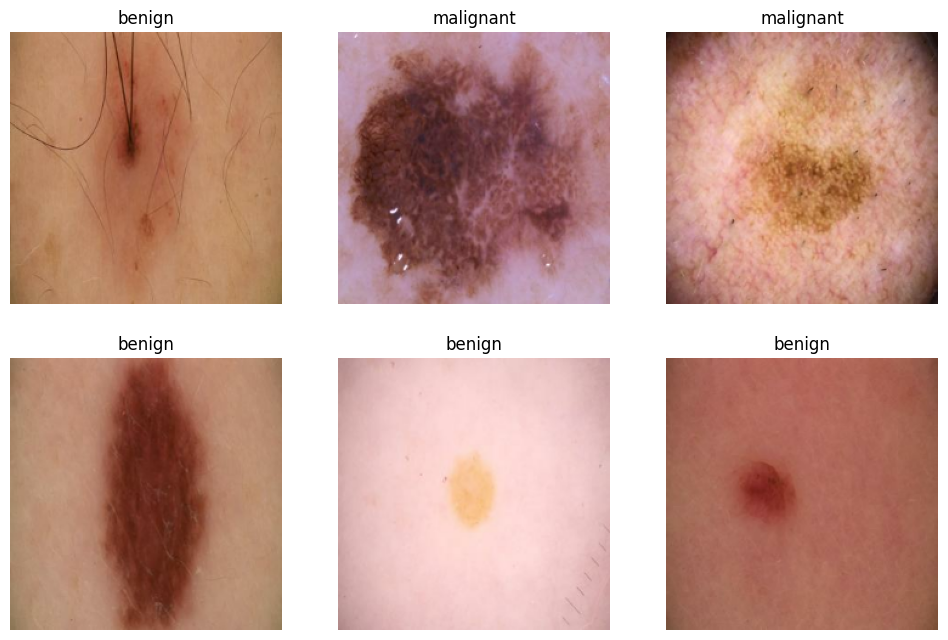

In [9]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in train_data.take(2):
    for i in range(6):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## splitting dataset

In [10]:
def get_datset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle = True, shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    train_size= int(train_split* ds_size)
    val_size=int(val_split * ds_size)
    train_ds = train_data.take(train_size)
    val_ds = train_data.skip(train_size).take(val_size)


    return train_ds, val_ds

In [13]:
train_ds, val_ds = get_datset_partitions_tf(train_data)

In [14]:
len(train_ds), len(val_ds)

(120, 30)

## Data Augmentation

In [15]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))),
    tf.keras.layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal" or "vertical"),
   layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
   layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
   #layers.RandomContrast(factor=0.1),              # Adjusts contrast randomly by up to 10%
   #layers.RandomBrightness(factor=0.1) 
])

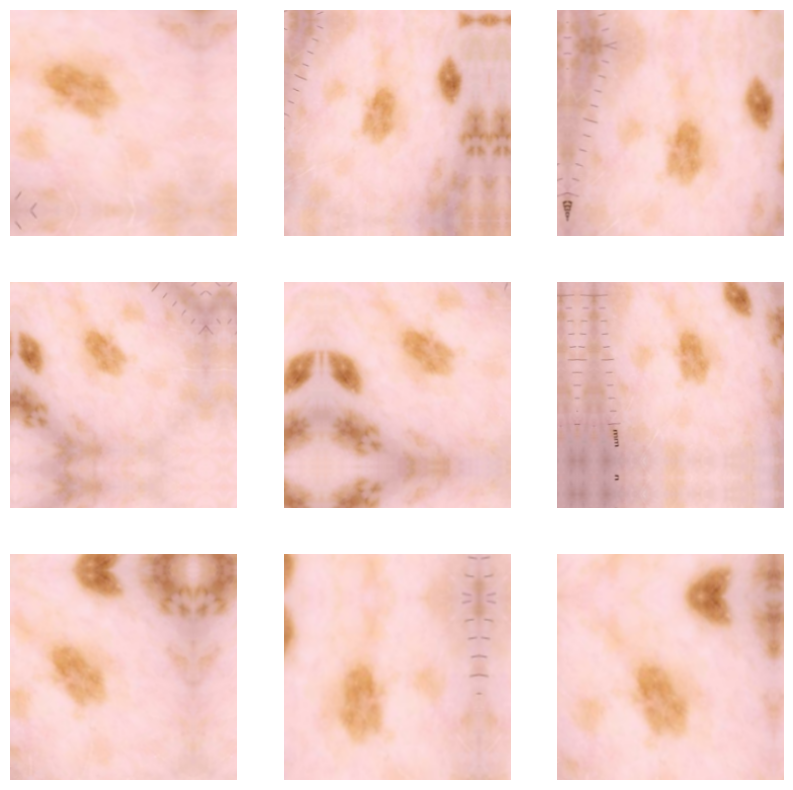

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(5):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## modelling

In [25]:
# from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import EfficientNetB0, ResNet50
# Load pre-trained model 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

# Add custom layers for fine-tuning
inputs = Input(shape=(224,224, 3))
x=resize_and_rescale(inputs)
x = data_augmentation(inputs)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(2, activation='sigmoid')(x)  

# Create the final fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
from keras import optimizers
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:

#checkpoint_path = "cancerseverity_model_checkpoint.weights.h5"
#checkpoint_callback = ModelCheckpoint(
                            #checkpoint_path,                             
                            #save_weights_only=True,                      
                            #monitor="val_loss",                       
                            #save_best_only=True
                             #)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

In [28]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1049s 9s/step - accuracy: 0.8678 - loss: 0.5156 - val_accuracy: 0.9286 - val_loss: 0.2132
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1026s 9s/step - accuracy: 0.9521 - loss: 0.1285 - val_accuracy: 0.9172 - val_loss: 0.2310
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1024s 9s/step - accuracy: 0.9746 - loss: 0.0643 - val_accuracy: 0.9370 - val_loss: 0.1988
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1019s 8s/step - accuracy: 0.9850 - loss: 0.0406 - val_accuracy: 0.9505 - val_loss: 0.1773
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1027s 8s/step - accuracy: 0.9925 - loss: 0.0272 - val_accuracy: 0.9458 - val_loss: 0.1971
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1062s 9s/step - accuracy: 0.9970 - loss: 0.0148 - val_accuracy: 0.9469 - val_loss: 0.1979
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1147s 10s/step - accuracy: 0.9968 - loss: 0.0113 - val_accuracy: 0.9484 - val_loss: 0.1750
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1236s 10s/step - accuracy: 0.9961 - loss: 0.0135 

### Evaluation

### test data

In [29]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_data:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=-1)
    y_pred.extend(predicted_labels)
    y_true.extend(label_batch.numpy())


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


In [32]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

#class_names=['benign', 'malignant']
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.923
              precision    recall  f1-score   support

      benign       0.91      0.94      0.92       500
   malignant       0.94      0.91      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



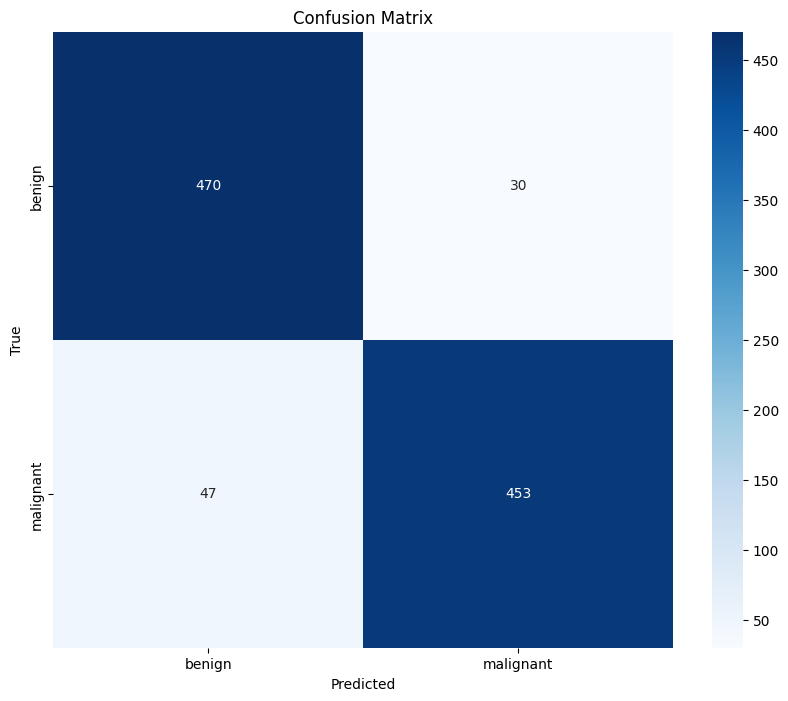

In [33]:
conf_matrix = confusion_matrix(y_true, y_pred)
target_names= class_names
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### validation data

In [34]:
y_pred_val = []
y_true_val = []

for image_batch, label_batch in val_ds:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=-1)
    y_pred_val.extend(predicted_labels)
    y_true_val.extend(label_batch.numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
2/2 ━━━━━

In [35]:
accuracy = accuracy_score(y_true_val, y_pred_val)
print("Accuracy:", accuracy)

#class_names=['benign', 'malignant']
print(classification_report(y_true_val, y_pred_val, target_names=class_names))

Accuracy: 0.9479166666666666
              precision    recall  f1-score   support

      benign       0.95      0.95      0.95      1029
   malignant       0.94      0.95      0.94       891

    accuracy                           0.95      1920
   macro avg       0.95      0.95      0.95      1920
weighted avg       0.95      0.95      0.95      1920



## save the model

In [37]:
model.save('severe_cancer_model2.keras')